# <center>Data Mining Project Code</center>

** **
## <center>*03 - XXXX*</center>

** **

In this notebook, we start our customer segmentation using two different partitioning methods: K-means and K-medoids. Each algorithm is going to be applied to different datasets which suffered from different transformations.

The members of the `team` are:
- Ana Farinha  - 20211514
- António Oliveira - 20211595
- Mariana Neto - 20211527
- Salvador Domingues - 20240597


# ToC

<a class="anchor" id="top"></a>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>

1. [Clustering](#2.-Clustering) <br><br>


In [1]:
import pandas as pd
import numpy as np
from IPython.display import display 

# Scalers
from sklearn.preprocessing import RobustScaler

# Clustering algorithms
from sklearn.cluster import KMeans

# Segmentation
import segmentation as s

# Visualizations
import matplotlib.pyplot as plt
import functions as f

pd.set_option('display.max_columns', None)

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Importing Libraries & Data

In [2]:
data = pd.read_csv('data/preprocessed_data.csv', 
                   index_col = "customer_id")
spending_data = data[s.spending_orders]
spending_data = data.select_dtypes(include=['float64', 'int64'])
spending_data

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,promo_DELIVERY,promo_DISCOUNT,promo_FREEBIE,pay_CARD,pay_CASH,last_promo_enc,payment_method_enc,days_between,total_orders,avg_order_hour,total_spend,avg_spend_prod,is_repeat_customer,avg_prod_vendor,avg_orders_vendor,avg_prod_order,weekend_orders,weekday_orders,weekend_weekday_ratio,num_cuisines,average_spend_per_cuisine,CUI_American_ratio,CUI_Asian_ratio,CUI_Beverages_ratio,CUI_Cafe_ratio,CUI_Chicken Dishes_ratio,CUI_Chinese_ratio,CUI_Desserts_ratio,CUI_Healthy_ratio,CUI_Indian_ratio,CUI_Italian_ratio,CUI_Japanese_ratio,CUI_Noodle Dishes_ratio,CUI_OTHER_ratio,CUI_Street Food / Snacks_ratio,CUI_Thai_ratio,DOW_0_ratio,DOW_1_ratio,DOW_2_ratio,DOW_3_ratio,DOW_4_ratio,DOW_5_ratio,DOW_6_ratio,HR_0_ratio,HR_1_ratio,HR_2_ratio,HR_3_ratio,HR_4_ratio,HR_5_ratio,HR_6_ratio,HR_7_ratio,HR_8_ratio,HR_9_ratio,HR_10_ratio,HR_11_ratio,HR_12_ratio,HR_13_ratio,HR_14_ratio,HR_15_ratio,HR_16_ratio,HR_17_ratio,HR_18_ratio,HR_19_ratio,HR_20_ratio,HR_21_ratio,HR_22_ratio,HR_23_ratio,0_7h,8_14h,15_19h,20_23h
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,2360,18.0,2,5,1,0,1,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,28.88,0.00,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,1.0,6090,1,2,18.0,28.88,5.776,1,2.5,1.0,2.5,2,0,2.0,1,28.880,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,2,0
5d272b9dcb,8670,17.0,2,2,2,0,1,12.82,6.39,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.0,6090,1,2,10.5,19.21,9.605,1,1.0,1.0,1.0,2,0,2.0,2,9.605,0.667361,0.332639,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0
f6d1b2ba63,4660,38.0,1,2,2,0,1,9.20,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2.0,5619,1,2,10.0,9.20,4.600,1,2.0,2.0,1.0,2,0,2.0,1,9.200,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0
180c632ed8,4660,26.0,2,3,1,0,2,0.00,13.70,0.00,0.0,0.0,0.0,0.00,0.0,17.86,0.00,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,6090,2,2,12.5,31.56,10.520,1,1.5,1.0,1.5,1,1,1.0,2,15.780,0.000000,0.434094,0.0,0.0,0.0,0.0,0.0,0.0,0.565906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0
4eb37a6705,4660,20.0,2,5,0,0,2,14.57,40.87,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6090,2,2,8.5,55.44,11.088,1,2.5,1.0,2.5,1,1,1.0,2,27.720,0.262807,0.737193,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# 2. Clustering

**Scale Data Before Clustering**

In [3]:
scaled_data = RobustScaler().fit_transform(spending_data)

## 2.1 Hierarchical Clustering

In [4]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [5]:
linkages = ['ward', 'complete', 'average', 'single']

**Dendrogram**

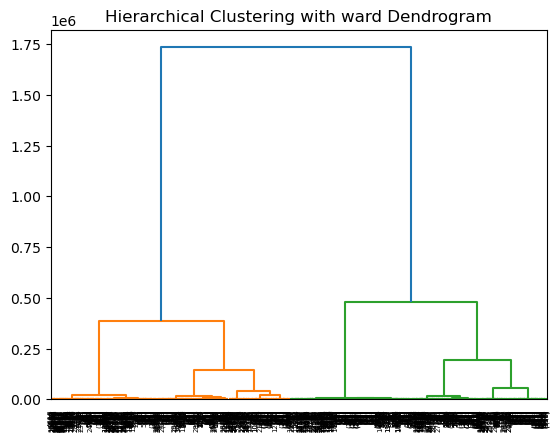

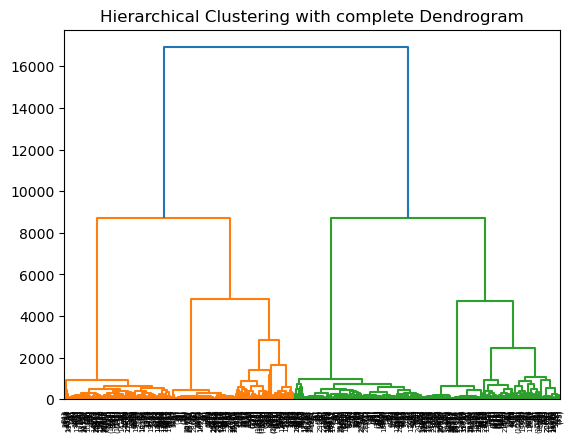

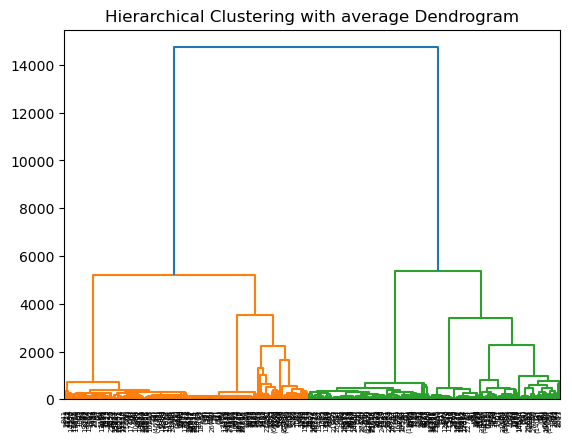

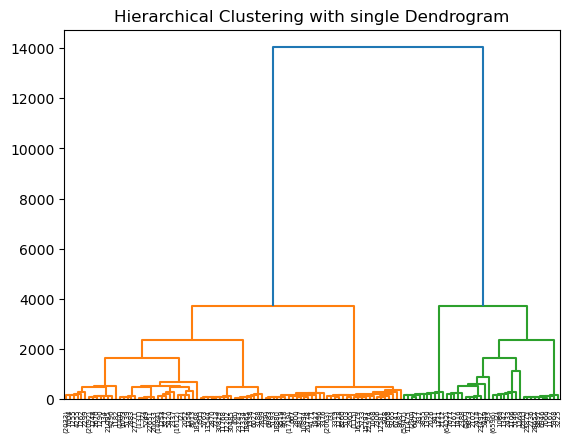

In [6]:
for linkage in linkages:
    agg_clust = AgglomerativeClustering(
        linkage = linkage, distance_threshold = 0, n_clusters=None
        ).fit(spending_data)
    
    fig, ax = plt.subplots()
    plt.title(f"Hierarchical Clustering with {linkage} Dendrogram")
    f.plot_dendrogram(agg_clust, truncate_mode="level", p=10)
    plt.show()

**R2**

In [10]:
# Let's wrap them into functions

def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.

    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.

    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.

    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


def get_ssw(df, feats, label_col):

    feats_label = feats+[label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats), 
                                                       include_groups=False)

    return df_k.sum()



In [11]:
def get_rsq(df, feats, label_col):
    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)
    

In [12]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        
        #get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        # concat df with labels
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        
        
        # append the R2 of the given cluster solution
        r2.append(get_rsq(df_concat, feats, 'labels'))
        
    return np.array(r2)


In [ ]:
max_nclus = 8

r2_hc = np.vstack([ f.get_r2_hc(spending_data, 
                              link, 
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in linkages])

In [43]:
r2_hc_methods = pd.DataFrame(r2_hc.T, 
                             index=range(1, max_nclus + 1), 
                             columns=linkages)

In [ ]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

**Final Solution for Hierarchical Clustering**

In [46]:
linkage = "ward"
distance = "euclidean"
n_clusters = 4

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels = hclust.fit_predict(spending_data)

In [ ]:
f.plot_cluster_profiling(spending_data, hc_labels, "Hierarchical")

## 2.2 K-Means

In [3]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(spending_data)
    dispersion.append(kmeans.inertia_)

**Elbow Method**

In [ ]:
plt.plot(range(1, 20), dispersion, marker='o', color='#4CAF50')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.xticks(np.arange(0, 21, step=2))  
#plt.vlines(7, 5000, 600000, color='red')

plt.show()

**Histogram**

In [8]:
possible_k = [2, 3, 4, 5, 6, 7, 8]

In [ ]:
for k in possible_k:
    
    spending_data_copy = spending_data.copy()
    
    kmeans = KMeans(n_clusters=k, random_state=42)  
    kmeans.fit(spending_data_copy)  
    clusters  = kmeans.predict(spending_data_copy)  
    
    spending_data_copy[f'cluster_kmeans{k}'] = clusters 
    
    spending_data_copy.groupby([f'cluster_kmeans{k}']).size().plot(kind='bar', 
                                                          color='#4CAF50') 
    plt.title(f'Cluster Sizes for k={k}')
    plt.show()

**Means**

In [ ]:
for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42)  
    kmeans.fit(spending_data)  
    clusters = kmeans.predict(spending_data)  

    # Add the cluster assignments to the DataFrame
    data[f'cluster_kmeans{k}'] = clusters 

    # Compute mean values grouped by clusters and transpose
    cluster_means = spending_data.groupby([f'cluster_kmeans{k}']).mean().T

    print(f"\nMean values for k={k}:")
    display(cluster_means)

**Silhouette Score**

In [ ]:
avg_silhouette = f.plot_silhouette(spending_data, possible_k)

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(possible_k, avg_silhouette, marker='o', label='Average Silhouette')
plt.ylabel("Average Silhouette Score")
plt.xlabel("Number of Clusters")
plt.title("Average Silhouette Plot over Clusters", fontsize=15)
plt.xticks(possible_k)
plt.grid(alpha=0.5)
plt.legend()
plt.show()


**Final Solution for K-Means**

In [ ]:
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, 
                 init='k-means++', 
                 n_init=15, 
                 random_state=1)

km_labels = kmclust.fit_predict(spending_data)
km_labels

In [ ]:
f.plot_cluster_profiling(spending_data, km_labels, "K-Means")

## 2.3 DB Scan

In [53]:
from sklearn.cluster import DBSCAN#, HDBSCAN

In [ ]:
dbscan = DBSCAN(eps=15, min_samples=5)  
spending_data['dbscan_cluster_1'] = dbscan.fit_predict(scaled_data)
spending_data['dbscan_cluster_1'].value_counts()

In [ ]:
# Create a bar chart of the number of customers in each cluster
cluster_counts = spending_data.groupby(['dbscan_cluster_1']).size()
ax = cluster_counts.plot(kind='bar', color='#4CAF50')

# Add labels to the x and y axes
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)

# Show the plot
plt.show()

### 2.3.1 HDB Scan

## 2.? UMAP

In [21]:
import umap.umap_ as umap

In [32]:
umap_object = umap.UMAP(n_neighbors=10, min_dist=0.1)

In [33]:
num_ordered = spending_data.sort_index()
umap_embedding = umap_object.fit_transform(num_ordered)

In [ ]:
f.plot_dim_reduction(umap_embedding)